In [14]:
import os
import zipfile
import pathlib
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader, TensorDataset

In [15]:
# Extract ZIP file
local_zip = './archive.zip'
if os.path.exists(local_zip) and zipfile.is_zipfile(local_zip):
    with zipfile.ZipFile(local_zip, 'r') as zip_ref:
        zip_ref.extractall('./')
    print("Zip file extracted.")
else:
    print("ZIP file not found.")

Zip file extracted.


In [16]:
# Dataset paths
train_dir = pathlib.Path("./dataset/training_set")
test_dir = pathlib.Path("./dataset/test_set")

In [17]:

# Load training images
cat_train = list(train_dir.glob('cats/*.jpg'))[:2200]
dog_train = list(train_dir.glob('dogs/*.jpg'))[:2200]

In [18]:
# Label mapping
images_dict = {'cats': cat_train, 'dogs': dog_train}
labels_dict = {'cats': 0, 'dogs': 1}

In [19]:
# Preprocess training data
X, y = [], []
for label, images in images_dict.items():
    for img_path in images:
        img = cv2.imread(str(img_path))
        img = cv2.resize(img, (224, 224))
        X.append(img)
        y.append(labels_dict[label])
X = np.array(X) / 255.0
X = np.transpose(X, (0, 3, 1, 2))  # (N, C, H, W)
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

In [21]:
# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X_tensor, y_tensor, test_size=0.3, random_state=20)
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=32)

In [22]:
# Define model
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.base_model = models.mobilenet_v2(pretrained=True).features
        for param in self.base_model.parameters():
            param.requires_grad = False
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(1280, 2)
        )

    def forward(self, x):
        x = self.base_model(x)
        x = self.classifier(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel().to(device)

c:\Users\wwwra\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\wwwra\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [23]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [24]:
# Train model
epochs = 5
train_acc_list, val_acc_list = [], []
train_loss_list, val_loss_list = [], []

for epoch in range(epochs):
    model.train()
    correct, total, loss_sum = 0, 0, 0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        outputs = model(Xb)
        loss = criterion(outputs, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_sum += loss.item()
        correct += (outputs.argmax(1) == yb).sum().item()
        total += yb.size(0)
    train_loss = loss_sum / len(train_loader)
    train_acc = correct / total
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    model.eval()
    correct, total, loss_sum = 0, 0, 0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            outputs = model(Xb)
            loss = criterion(outputs, yb)
            loss_sum += loss.item()
            correct += (outputs.argmax(1) == yb).sum().item()
            total += yb.size(0)
    val_loss = loss_sum / len(val_loader)
    val_acc = correct / total
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

    print(f"Epoch {epoch+1}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")


Epoch 1: Train Acc=0.9279, Val Acc=0.9568
Epoch 2: Train Acc=0.9549, Val Acc=0.9614
Epoch 3: Train Acc=0.9607, Val Acc=0.9576
Epoch 4: Train Acc=0.9571, Val Acc=0.9621
Epoch 5: Train Acc=0.9620, Val Acc=0.9530


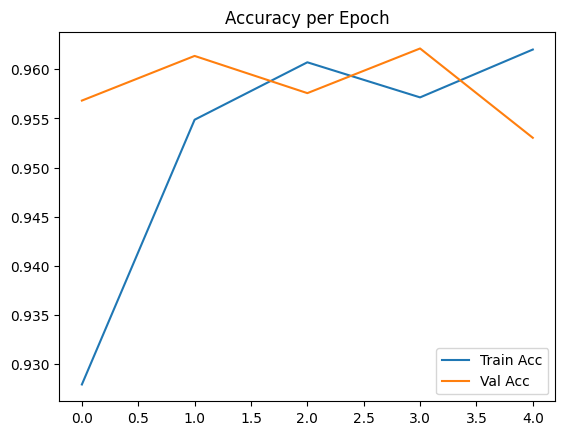

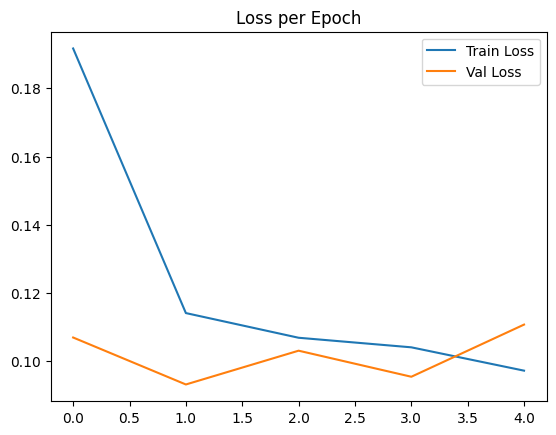

In [25]:
# Plot accuracy/loss
plt.plot(train_acc_list, label='Train Acc')
plt.plot(val_acc_list, label='Val Acc')
plt.title("Accuracy per Epoch")
plt.legend()
plt.show()

plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Val Loss')
plt.title("Loss per Epoch")
plt.legend()
plt.show()

In [26]:
# Test data processing
cat_test = list(test_dir.glob('cats/*.jpg'))
dog_test = list(test_dir.glob('dogs/*.jpg'))

test_images_dict = {'cats': cat_test, 'dogs': dog_test}
X_test, y_test = [], []
for label, images in test_images_dict.items():
    for img_path in images:
        img = cv2.imread(str(img_path))
        img = cv2.resize(img, (224, 224))
        X_test.append(img)
        y_test.append(labels_dict[label])
X_test = np.array(X_test) / 255.0
X_test = np.transpose(X_test, (0, 3, 1, 2))
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [27]:
# Test accuracy
model.eval()
with torch.no_grad():
    preds = model(X_test_tensor.to(device)).argmax(1).cpu()
    acc = (preds == y_test_tensor).float().mean()
print(f"Test Accuracy: {acc:.4f}")

Test Accuracy: 0.9660


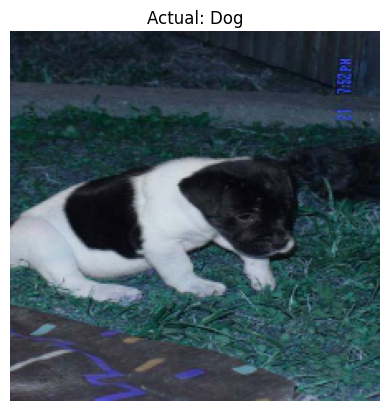

Predicted: Dog


In [28]:
# Predict a random image
class_names = ["Cat", "Dog"]
idx = random.randint(0, len(X_test_tensor) - 1)
sample_img = X_test_tensor[idx]
true_label = y_test_tensor[idx]

plt.imshow(np.transpose(sample_img.numpy(), (1, 2, 0)))
plt.title(f"Actual: {class_names[true_label]}")
plt.axis('off')
plt.show()

with torch.no_grad():
    pred = model(sample_img.unsqueeze(0).to(device)).argmax(1).item()
print(f"Predicted: {class_names[pred]}")

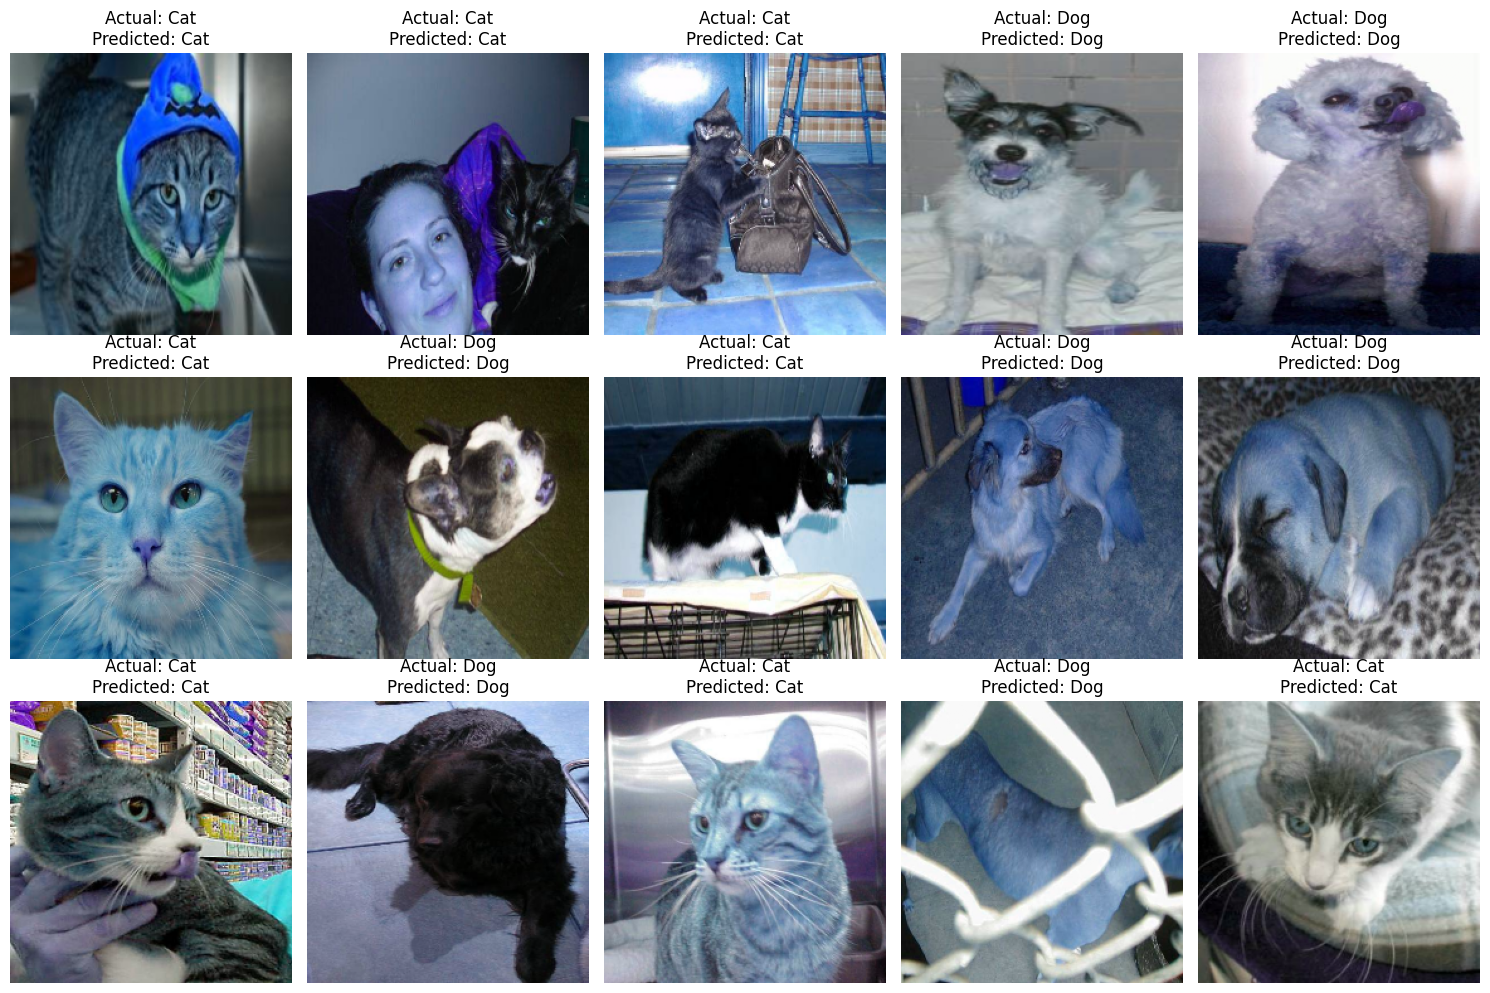

In [29]:
# Show 15 predictions
plt.figure(figsize=(15, 10))
for i in range(15):
    idx = random.randint(0, len(X_test_tensor) - 1)
    img = X_test_tensor[idx]
    true_label = y_test_tensor[idx]
    with torch.no_grad():
        pred = model(img.unsqueeze(0).to(device)).argmax(1).item()
    plt.subplot(3, 5, i + 1)
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.title(f"Actual: {class_names[true_label]}\nPredicted: {class_names[pred]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [56]:
# Predict user image
def predict_user_image(image_path, threshold=0.7):
    try:
        img = cv2.imread(image_path)
        if img is None:
            print("Invalid image.")
            return
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()
        img = cv2.resize(img, (224, 224))
        img = img / 255.0
        img = np.transpose(img, (2, 0, 1))
        img_tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0).to(device)
        with torch.no_grad():
            outputs = model(img_tensor)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()[0]
            pred = np.argmax(probs)
            confidence = probs[pred]
        if confidence < threshold:
            print("Prediction: Unknown")
        else:
            print(f"Prediction: {class_names[pred]} (Confidence: {confidence:.2f})")
    except Exception as e:
        print("Error:", e)

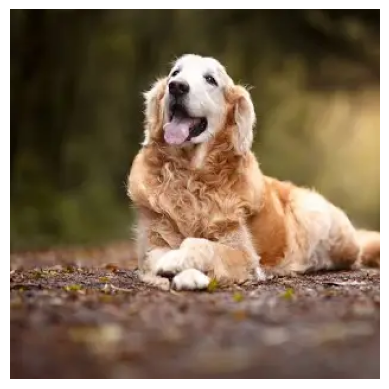

Prediction: Dog (Confidence: 1.00)


In [57]:
predict_user_image('./dog.webp')  # Example path, change as needed

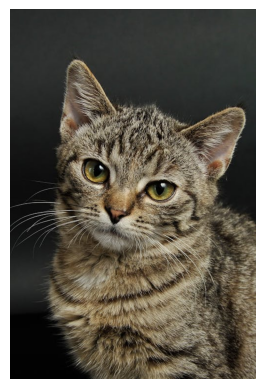

Prediction: Cat (Confidence: 1.00)


In [58]:
predict_user_image('./cat.jpeg')  # Example path, change as needed

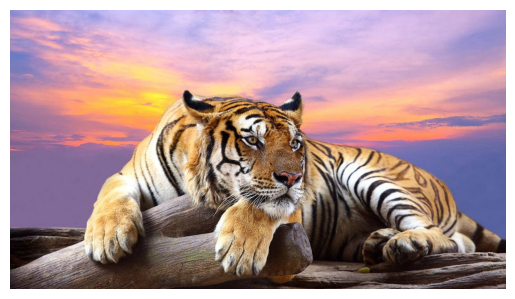

Prediction: Unknown


In [59]:
predict_user_image("./tiger.jpg")

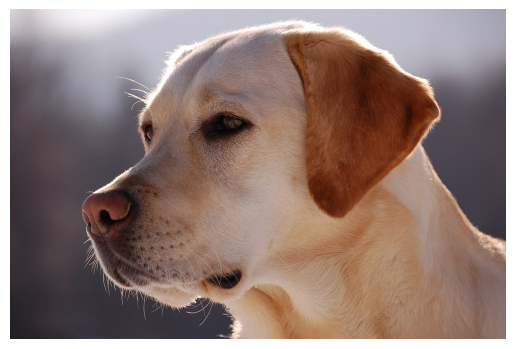

Prediction: Dog (Confidence: 1.00)


In [61]:
predict_user_image('./dog.jpg')  

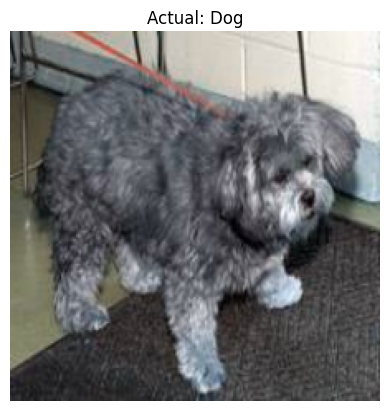

Predicted: Dog


In [62]:
# Predict a random image
class_names = ["Cat", "Dog"]
idx = random.randint(0, len(X_test_tensor) - 1)
sample_img = X_test_tensor[idx]
true_label = y_test_tensor[idx]

plt.imshow(np.transpose(sample_img.numpy(), (1, 2, 0)))
plt.title(f"Actual: {class_names[true_label]}")
plt.axis('off')
plt.show()

with torch.no_grad():
    pred = model(sample_img.unsqueeze(0).to(device)).argmax(1).item()
print(f"Predicted: {class_names[pred]}")

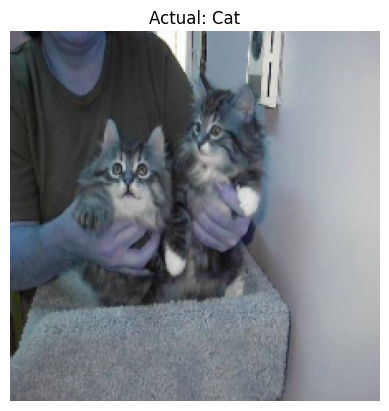

Predicted: Cat


In [63]:
# Predict a random image
class_names = ["Cat", "Dog"]
idx = random.randint(0, len(X_test_tensor) - 1)
sample_img = X_test_tensor[idx]
true_label = y_test_tensor[idx]

plt.imshow(np.transpose(sample_img.numpy(), (1, 2, 0)))
plt.title(f"Actual: {class_names[true_label]}")
plt.axis('off')
plt.show()

with torch.no_grad():
    pred = model(sample_img.unsqueeze(0).to(device)).argmax(1).item()
print(f"Predicted: {class_names[pred]}")